**Procedure for filtering data**

Step 1) Define frequency-domain shape and cut-offs

Step 2) Generate filter kernel(firls, fir1, butter, or other)

Step 3) Evaluate kernel and its power spectrum

Step 4) Apply filter kernel to data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## FIR filters with firls

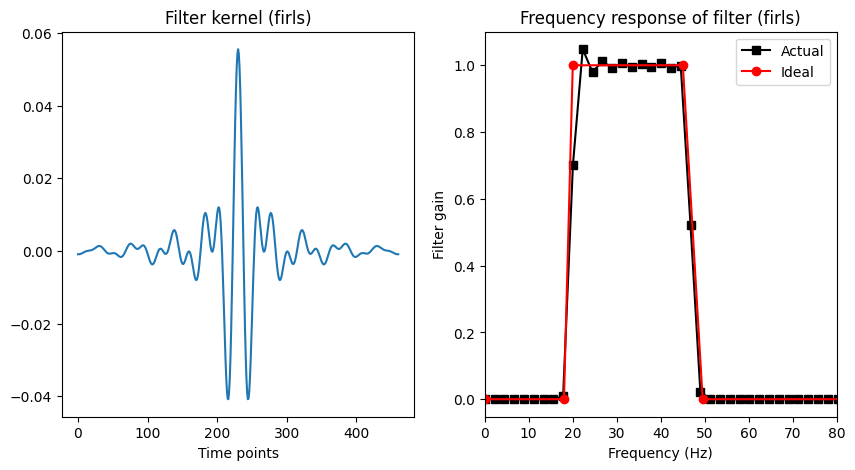

In [2]:
# Sampling rate and Nyquist frequency
srate = 1024
nyquist = srate / 2  # Nyquist frequency is half the sampling rate

# Frequency range for the band-pass filter
frange = [20, 45]  # Passband from 20 Hz to 45 Hz
transw = .1  # Transition width (as a percentage of the low cutoff frequency)

# Filter order, with an empirical formula based on the lowest cutoff frequency
order = int(9 * srate / frange[0])

# Ensure the filter order is odd for better symmetry (required for linear phase filters)
if order % 2 == 0:
    order += 1

# Define the filter shape and frequency breakpoints
# 'shape' describes the desired filter gain at the frequencies defined in 'frex'
shape = [0, 0, 1, 1, 0, 0]  # Zero gain at low and high frequencies, one gain in the passband
frex = [0,                          # Start at 0 Hz
        frange[0] - frange[0] * transw,  # Start of transition to passband (with transition width)
        frange[0],                    # Start of passband
        frange[1],                    # End of passband
        frange[1] + frange[1] * transw,  # End of transition from passband
        nyquist]                      # Nyquist frequency (end)

# Design a finite impulse response filter using the least-squares method
filtkern = scipy.signal.firls(order, frex, shape, fs=srate)

# Compute the power spectrum of the filter kernel using FFT
filtpow = abs(scipy.fftpack.fft(filtkern)) ** 2

# Create a frequency vector for plotting the frequency response
hz = np.linspace(0, srate / 2, int(np.floor(len(filtkern) / 2) + 1))

# Keep only the positive half of the frequency spectrum
filtpow = filtpow[:len(hz)]

# Plot the filter kernel (time domain) and the frequency response
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the filter kernel in the time domain
ax[0].plot(filtkern)
ax[0].set_xlabel('Time points')
ax[0].set_title('Filter kernel (firls)')  # FIR Least-squares filter

# Plot the frequency response of the filter
ax[1].plot(hz, filtpow, 'ks-', label='Actual')  # Actual filter response
ax[1].plot(frex, shape, 'ro-', label='Ideal')  # Ideal filter response
ax[1].set_xlim([0, frange[0] * 4])  # Show frequency range up to 4x lower cutoff
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Filter gain')
ax[1].legend()
ax[1].set_title('Frequency response of filter (firls)')

# Display the plots
plt.show()

## FIR filters with fir1(Zero transition zone)

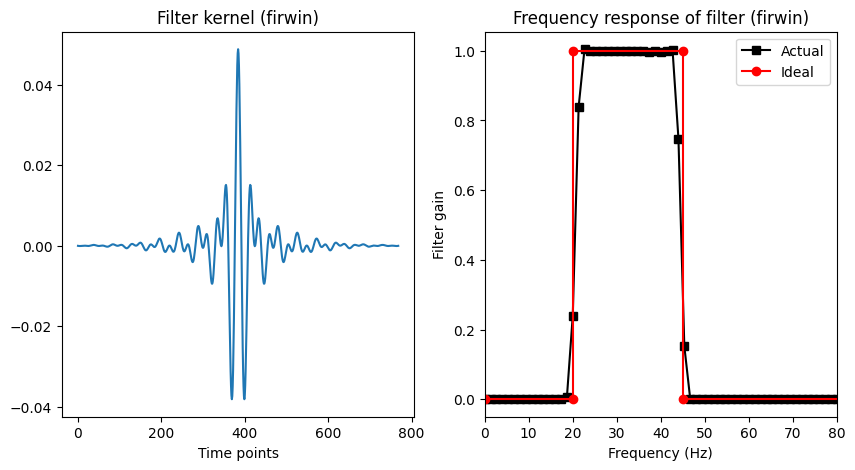

In [3]:
# Define the sampling rate and Nyquist frequency
srate = 1024
nyquist = srate / 2  # Nyquist frequency is half the sampling rate

# Frequency range for the band-pass filter
frange = [20, 45]  # Passband from 20 Hz to 45 Hz

# Calculate filter order using an empirical formula based on the lower cutoff frequency
order = int(15 * srate / frange[0])

# Ensure the filter order is odd (as is required for symmetry in linear-phase FIR filters)
if order % 2 == 0:
    order += 1

# Design a FIR band-pass filter using the 'firwin' method
# 'pass_zero=False' creates a band-pass filter
filtkern = scipy.signal.firwin(order, frange, fs=srate, pass_zero=False)

# Compute the power spectrum of the filter kernel using FFT
filtpow = abs(scipy.fftpack.fft(filtkern))**2

# Create a frequency vector for plotting the frequency response
hz = np.linspace(0, srate / 2, int(np.floor(len(filtkern) / 2) + 1))

# Keep only the positive half of the frequency spectrum
filtpow = filtpow[:len(hz)]

# Create subplots for time-domain filter kernel and its frequency response
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the filter kernel (time domain) in the first subplot
ax[0].plot(filtkern)
ax[0].set_xlabel('Time points')
ax[0].set_title('Filter kernel (firwin)')

# Plot the amplitude spectrum of the filter kernel (frequency domain) in the second subplot
ax[1].plot(hz, filtpow, 'ks-', label='Actual')  # Actual filter response from the FFT
ax[1].plot([0, frange[0], frange[0], frange[1], frange[1], nyquist], 
           [0, 0, 1, 1, 0, 0], 'ro-', label='Ideal')  # Ideal band-pass response
ax[1].set_xlim([0, frange[0] * 4])  # Limit x-axis to a range up to 4x the lower cutoff
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Filter gain')
ax[1].legend()
ax[1].set_title('Frequency response of filter (firwin)')

# Display the plots
plt.show()


## IIR Butterworth filters

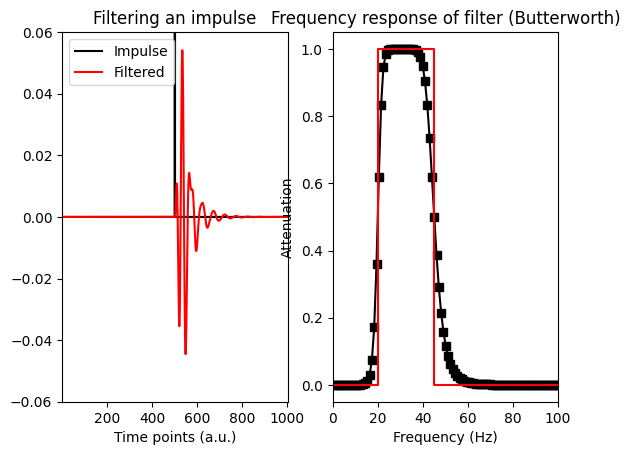

In [4]:
# Sampling rate and Nyquist frequency
srate = 1024
nyquist = srate / 2  # Nyquist frequency is half the sampling rate

# Frequency range for the band-pass filter
frange = [20, 45]  # Passband from 20 Hz to 45 Hz

# Design a 4th-order Butterworth band-pass filter
# The frequency cutoff is normalized by dividing by the Nyquist frequency
fkernB, fkernA = scipy.signal.butter(4, np.array(frange) / nyquist, btype="bandpass")

# Compute the frequency response (magnitude) of the filter using FFT
filtpow = abs(scipy.fftpack.fft(fkernB))

# Generate an impulse (a signal with a single spike at the center)
impres = np.zeros(1001)  # Impulse response array with 1001 samples
impres[501] = 1  # Set the 501st sample to 1 (impulse)

# Apply the Butterworth filter to the impulse
fimp = scipy.signal.lfilter(fkernB, fkernA, impres, axis=-1)

# Compute the power spectrum (magnitude squared of the FFT) of the filtered impulse
fimpX = np.abs(scipy.fftpack.fft(fimp)) ** 2

# Create a frequency vector for plotting the frequency response
hz = np.linspace(0, nyquist, int(np.floor(len(impres) / 2) + 1))

# Plot the time-domain response of the filtered impulse
plt.subplot(121)
plt.plot(impres, 'k', label='Impulse')  # Original impulse
plt.plot(fimp, 'r', label='Filtered')  # Filtered impulse
plt.xlim([1, len(impres)])
plt.ylim([-.06, .06])
plt.legend()
plt.xlabel('Time points (a.u.)')
plt.title('Filtering an impulse')

# Plot the frequency response of the filter
plt.subplot(122)
plt.plot(hz, fimpX[0:len(hz)], 'ks-')  # Power spectrum of the filtered impulse
plt.plot([0, frange[0], frange[0], frange[1], frange[1], nyquist], [0, 0, 1, 1, 0, 0], 'r')  # Ideal response
plt.xlim([0, 100])  # Frequency axis up to 100 Hz
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth)')

# Display the plots
plt.show()

## Causal and Zero-phase-shift filters

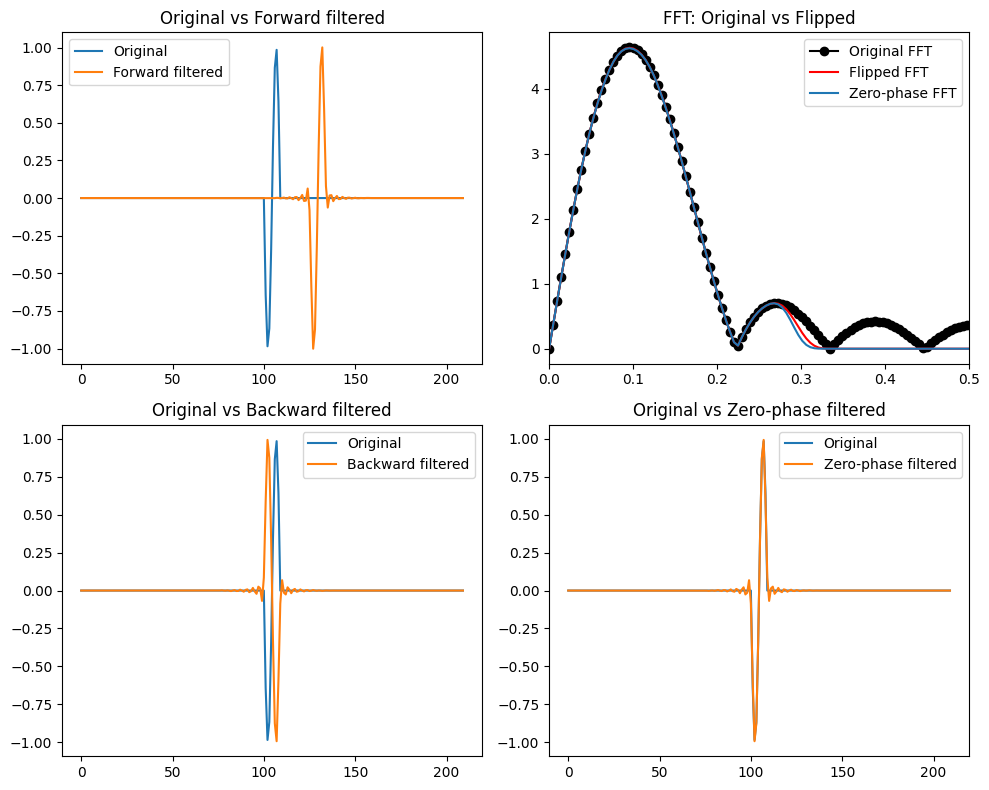

In [5]:
# Generate a signal: concatenation of zero-padded cosine wave
signal = np.concatenate((np.zeros(100), np.cos(np.linspace(np.pi/2, 5*np.pi/2, 10)), np.zeros(100)), axis=0)
n = len(signal)

# Design a low-pass FIR filter using firwin
fkern = scipy.signal.firwin(51, .6)

# Apply forward filtering (normal filtering)
fsignal = scipy.signal.lfilter(fkern, 1, signal)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# 1st subplot: Compare original signal and forward filtered signal
axs[0, 0].plot(range(0, n), signal, label='Original')
axs[0, 0].plot(range(0, n), fsignal, label='Forward filtered')
axs[0, 0].set_title('Original vs Forward filtered')
axs[0, 0].legend()

# 2nd subplot: Compare FFTs of original and reversed filtered signals
fsignalF = fsignal[::-1]  # Reverse the filtered signal for the next step

# Plot the original FFT and the flipped FFT
axs[0, 1].plot(np.linspace(0, 1, n), np.abs(scipy.fft.fft(signal)), 'ko-', label='Original FFT')
axs[0, 1].plot(np.linspace(0, 1, n), np.abs(scipy.fft.fft(fsignalF)), 'r', label='Flipped FFT')
axs[0, 1].set_xlim([0, .5])  # Limit x-axis to Nyquist frequency
axs[0, 1].set_title('FFT: Original vs Flipped')

# 3rd subplot: Backward filtering the reversed signal
fsignalF = scipy.signal.lfilter(fkern, 1, fsignalF)  # Apply forward filter on reversed signal
axs[1, 0].plot(range(0, n), signal, label='Original')
axs[1, 0].plot(range(0, n), fsignalF, label='Backward filtered')
axs[1, 0].set_title('Original vs Backward filtered')
axs[1, 0].legend()

# 4th subplot: Zero-phase filtering by reversing again
fsignalF = fsignalF[::-1]  # Reverse again to achieve zero-phase filtering
axs[1, 1].plot(range(0, n), signal, label='Original')
axs[1, 1].plot(range(0, n), fsignalF, label='Zero-phase filtered')
axs[1, 1].set_title('Original vs Zero-phase filtered')
axs[1, 1].legend()

# Plot the FFT of the zero-phase filtered signal in the 2nd subplot
axs[0, 1].plot(np.linspace(0, 1, n), np.abs(scipy.fft.fft(fsignalF)), label='Zero-phase FFT')
axs[0, 1].legend()

# Adjust layout to avoid overlapping subplots
plt.tight_layout()
plt.show()

## Avoid edge effects with reflection

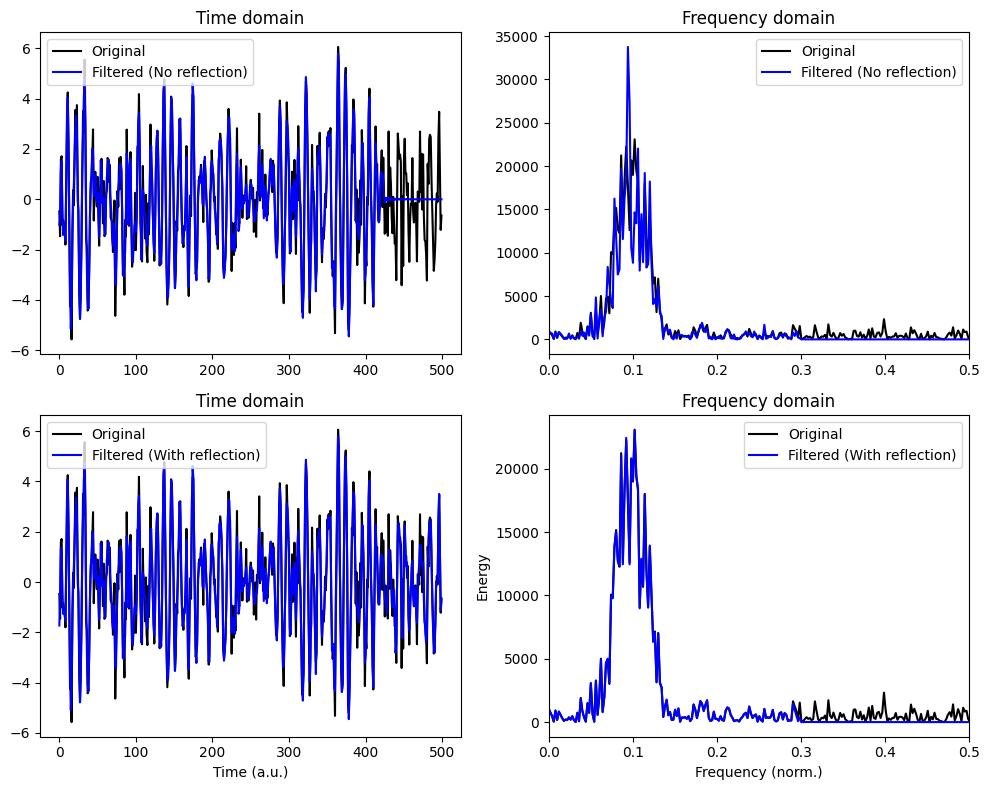

In [6]:
# Define signal parameters
N = 500  # Length of the signal
hz = np.linspace(0, 1, N)  # Frequency vector
gau = np.exp(-(4*np.log(2)*(hz - 0.1) / 0.1)**2) * N / 2  # Gaussian window
signal = np.real(scipy.fft.ifft(gau * np.exp(1j * np.random.rand(N) * 2 * np.pi))) + np.random.randn(N)  # Generate noisy signal

# Design the FIR filter
order = 151  # Filter order
fkern = scipy.signal.firwin(order, 0.6)  # FIR filter design (low-pass)

# Zero-phase-shift filtering (without reflection)
fdata = scipy.signal.lfilter(fkern, 1, signal)  # Forward filter
fdata = scipy.signal.lfilter(fkern, 1, fdata[::-1])  # Reverse filter
fdata = fdata[::-1]  # Flip forward to achieve zero-phase filtering

# Plot original and filtered signals (No reflection)
plt.figure(figsize=(10,8))

# Time domain plot
plt.subplot(221)
plt.plot(range(0, N), signal, 'k', label='Original')  # Original signal
plt.plot(range(0, N), fdata, 'b', label='Filtered (No reflection)')  # Filtered signal
plt.title('Time domain')
plt.legend()

# Power spectra comparison (no reflection)
plt.subplot(222)
plt.plot(hz, np.abs(scipy.fft.fft(signal))**2, 'k', label='Original')  # Original signal spectrum
plt.plot(hz, np.abs(scipy.fft.fft(fdata))**2, 'b', label='Filtered (No reflection)')  # Filtered spectrum
plt.title('Frequency domain')
plt.xlim([0, 0.5])
plt.legend()

# Zero-phase-shift filtering with reflection to reduce edge artifacts
reflectdata = np.concatenate((signal[order:0:-1], signal, signal[-1:-1-order:-1]), axis=0)  # Extend signal with reflection

# Apply zero-phase-shift filter on the reflected signal
reflectdata = scipy.signal.lfilter(fkern, 1, reflectdata)  # Forward filter
reflectdata = scipy.signal.lfilter(fkern, 1, reflectdata[::-1])  # Reverse filter
reflectdata = reflectdata[::-1]  # Flip forward again

# Remove the reflected parts to restore original signal size
fdata_reflected = reflectdata[order: -order]

# Plot the time-domain comparison again (cleaner with reflection)
plt.subplot(223)
plt.plot(range(0, N), signal, 'k', label='Original')  # Original signal
plt.plot(range(0, N), fdata_reflected, 'b', label='Filtered (With reflection)')  # Filtered signal with reflection
plt.xlabel('Time (a.u.)')
plt.title('Time domain')
plt.legend()

# Frequency domain spectra comparison (with reflection)
plt.subplot(224)
plt.plot(hz, np.abs(scipy.fft.fft(signal))**2, 'k', label='Original')  # Original signal spectrum
plt.plot(hz, np.abs(scipy.fft.fft(fdata_reflected))**2, 'b', label='Filtered (With reflection)')  # Filtered spectrum
plt.legend()
plt.xlim([0, 0.5])
plt.xlabel('Frequency (norm.)')
plt.ylabel('Energy')
plt.title('Frequency domain')

plt.tight_layout()
plt.show()

## Low-Pass filter

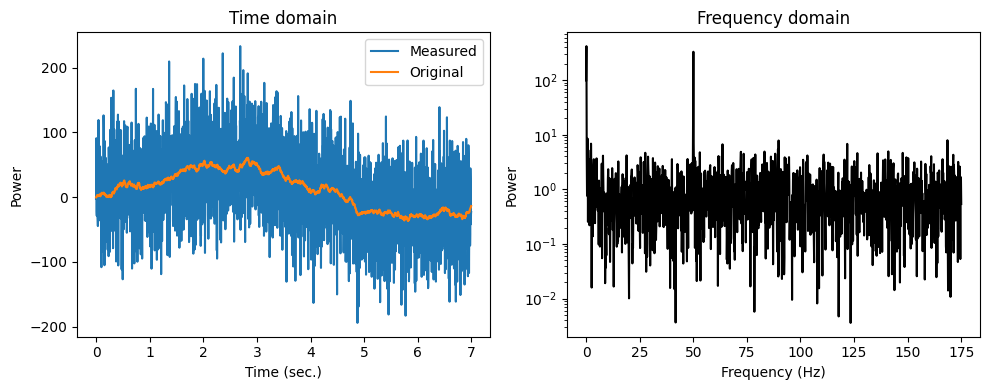

In [7]:
# Sampling frequency and time vector
fs = 350  # Sampling frequency (Hz)
timevec = np.arange(0, fs*7 - 1) / fs  # Time vector covering 7 seconds
npnts = len(timevec)  # Number of samples

# Generate original signal
yOrig = np.cumsum(np.random.randn(npnts))  # Random walk signal
y = yOrig + 50*np.random.randn(npnts) + 40*np.sin(2*np.pi*50*timevec)  # Measured signal with noise and 50 Hz sinusoid

# Compute power spectrum of the measured signal
yX = abs(scipy.fft.fft(y) / npnts)**2  # FFT and power spectrum
hz = np.linspace(0, fs/2, int(np.floor(npnts/2) + 1))  # Frequency axis

# Plot time-domain and frequency-domain representations
plt.figure(figsize=(10, 4))

# Time domain plot
plt.subplot(1, 2, 1)
plt.plot(timevec, y, label='Measured')  # Plot the noisy measured signal
plt.plot(timevec, yOrig, label='Original')  # Plot the original random walk signal
plt.xlabel('Time (sec.)')
plt.ylabel('Power')
plt.title('Time domain')
plt.legend()

# Frequency domain plot (power spectrum)
plt.subplot(1, 2, 2)
plt.plot(hz, yX[0:len(hz)], 'k')  # Plot the power spectrum in the frequency domain
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency domain')
plt.yscale('log')  # Logarithmic scale to show frequency components more clearly

plt.tight_layout()
plt.show()

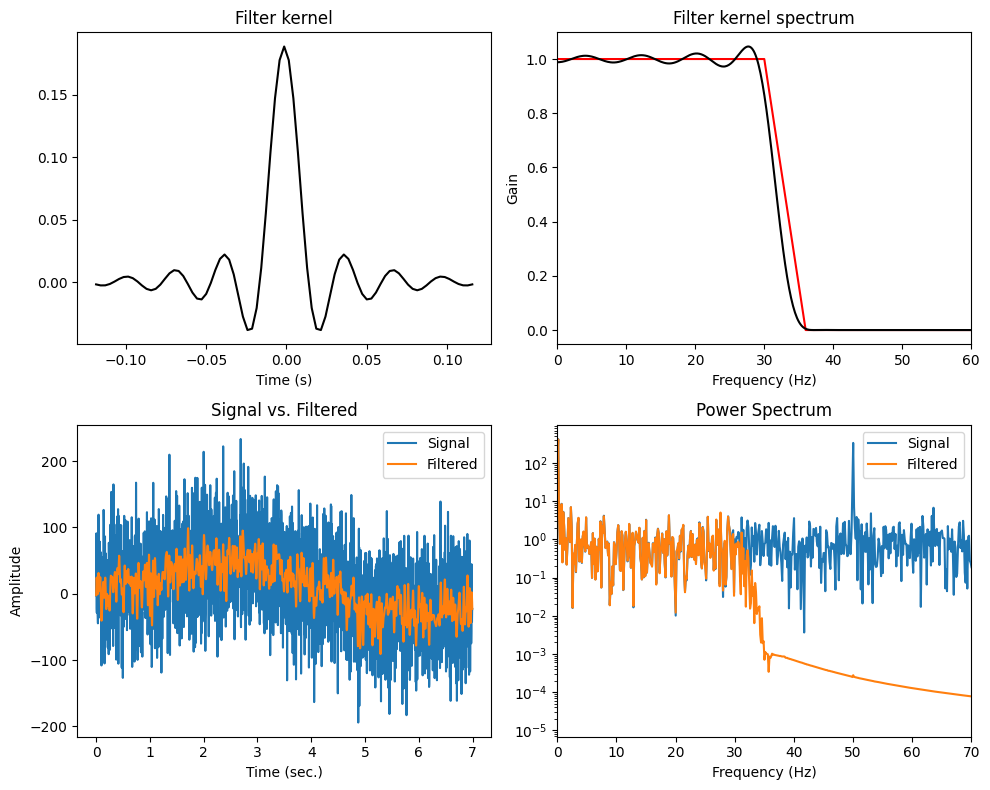

In [8]:
# Define signal and filter parameters
fs = 350  # Sampling frequency (Hz)
fcutoff = 30  # Cutoff frequency for the low-pass filter (Hz)
transw = 0.2  # Transition width as a fraction of the cutoff frequency
order = np.round(7 * fs / fcutoff) + 1  # Filter order (based on the cutoff frequency)

# Define frequency response for the filter
shape = [1, 1, 0, 0]  # Passband (1), stopband (0)
frex = [0, fcutoff, fcutoff + fcutoff * transw, fs / 2]  # Frequency points for filter design

# Generate filter kernel using least-squares method
filtkern = scipy.signal.firls(order, frex, shape, fs=fs)

# Compute the filter's power spectrum
filtkernX = np.abs(scipy.fftpack.fft(filtkern, npnts))**2

# Create 2x2 subplots for different visualizations
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot: Filter kernel in the time domain
axs[0, 0].plot(np.arange(-order / 2, order / 2) / fs, filtkern, 'k')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_title('Filter kernel')

# Second subplot: Frequency response of filter kernel
axs[0, 1].plot(np.array(frex), shape, 'r')  # Desired frequency response
axs[0, 1].plot(hz, filtkernX[:len(hz)], 'k')  # Actual frequency response
axs[0, 1].set_xlim([0, 60])
axs[0, 1].set_xlabel('Frequency (Hz)')
axs[0, 1].set_ylabel('Gain')
axs[0, 1].set_title('Filter kernel spectrum')

# Apply the filter to the noisy signal
yFilt = scipy.signal.filtfilt(filtkern, 1, y)  # Zero-phase filtering

# Third subplot: Compare original and filtered signals (time domain)
axs[1, 0].plot(timevec, y, label='Signal')  # Plot the original signal
axs[1, 0].plot(timevec, yFilt, label='Filtered')  # Plot the filtered signal
axs[1, 0].legend()
axs[1, 0].set_xlabel('Time (sec.)')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].set_title('Signal vs. Filtered')

# Compute power spectra of the original and filtered signals
yOrigX = np.abs(scipy.fftpack.fft(y) / npnts)**2  # Power spectrum of original signal
yFiltX = np.abs(scipy.fftpack.fft(yFilt) / npnts)**2  # Power spectrum of filtered signal

# Fourth subplot: Compare power spectra (frequency domain)
axs[1, 1].plot(hz, yOrigX[:len(hz)], label='Signal')  # Original power spectrum
axs[1, 1].plot(hz, yFiltX[:len(hz)], label='Filtered')  # Filtered power spectrum
axs[1, 1].set_xlim([0, fs / 5])
axs[1, 1].set_yscale('log')  # Log scale for better comparison
axs[1, 1].legend()
axs[1, 1].set_xlabel('Frequency (Hz)')
axs[1, 1].set_title('Power Spectrum')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Windowed-sinc filter(Low-pass)

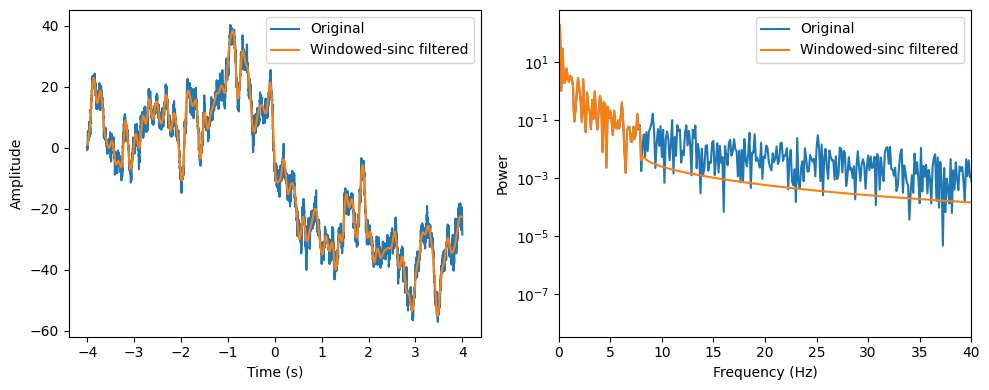

In [9]:
# Simulation parameters
srate = 1000  # Sampling rate
time = np.arange(-4, 4, 1/srate)  # Time vector
pnts = len(time)  # Number of points

# Create sinc filter
f = 8  # Filter frequency (Hz)
sincfilt = np.sin(2*np.pi*f*time) / time  # Sinc function
sincfilt[~np.isfinite(sincfilt)] = np.max(sincfilt)  # Handle NaN (at time = 0)
sincfilt = sincfilt / np.sum(sincfilt)  # Normalize filter

# Windowed sinc filter
sincfiltW = sincfilt * np.hanning(pnts)  # Apply Hann window

# Generate data (random walk)
data = np.cumsum(np.random.randn(pnts))

# Reflection for zero-phase filtering
datacat = np.concatenate((data, data[::-1]), axis=0)

# Apply the filter (zero-phase shift)
dataf = scipy.signal.lfilter(sincfiltW, 1, datacat)  # Forward filtering
dataf = scipy.signal.lfilter(sincfiltW, 1, dataf[::-1])  # Reverse filtering
dataf = dataf[-1:pnts-1:-1]  # Flip back to original

# Compute power spectra
powOrig = np.abs(scipy.fftpack.fft(data) / pnts)**2
powFilt = np.abs(scipy.fftpack.fft(dataf) / pnts)**2

# Plotting
plt.figure(figsize=(10, 4))

# Time domain plot
plt.subplot(1, 2, 1)
plt.plot(time, data, label='Original')
plt.plot(time, dataf, label='Windowed-sinc filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Frequency domain plot
hz = np.linspace(0, srate / 2, int(np.floor(pnts / 2) + 1))
plt.subplot(1, 2, 2)
plt.plot(hz, powOrig[:len(hz)], label='Original')
plt.plot(hz, powFilt[:len(hz)], label='Windowed-sinc filtered')
plt.xlim([0, 40])
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

plt.tight_layout()
plt.show()

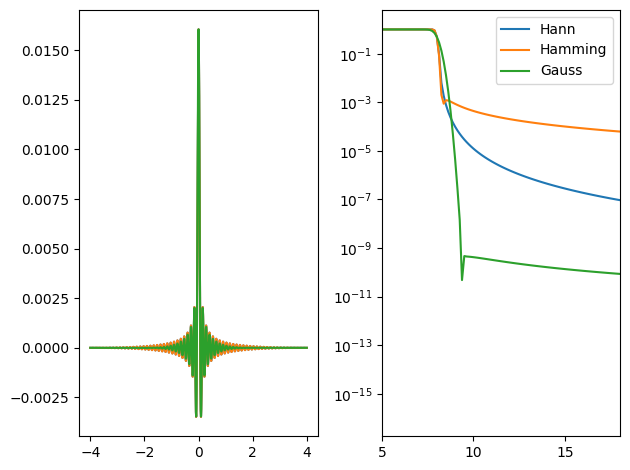

In [10]:
# Simulation parameters
srate = 1000  # Sampling rate
time = np.arange(-4, 4, 1/srate)  # Time vector
pnts = len(time)  # Number of points
f = 8  # Filter frequency

# Create sinc filter
sincfilt = np.sin(2 * np.pi * f * time) / time
sincfilt[~np.isfinite(sincfilt)] = np.max(sincfilt)  # Handle NaN (at time = 0)
sincfilt = sincfilt / np.sum(sincfilt)  # Normalize filter

# Initialize arrays for filtered signals with different windows
sincfiltW = np.zeros((3, pnts))

# Taper window names
tapernames = ['Hann', 'Hamming', 'Gauss']

# Apply Hann window
hannw = 0.5 - 0.5 * np.cos(2 * np.pi * np.linspace(0, 1, pnts))
sincfiltW[0, :] = sincfilt * hannw

# Apply Hamming window
hammingw = 0.54 - 0.46 * np.cos(2 * np.pi * np.linspace(0, 1, pnts))
sincfiltW[1, :] = sincfilt * hammingw

# Apply Gaussian window
sincfiltW[2, :] = sincfilt * np.exp(-time**2)

# Plot results for each windowing function
for filti in range(0, len(sincfiltW)):
    plt.subplot(121)
    plt.plot(time, sincfiltW[filti, :], label=tapernames[filti])
    
    plt.subplot(122)
    pw = np.abs(scipy.fftpack.fft(sincfiltW[filti, :]))
    plt.plot(np.linspace(0, srate/2, int(np.floor(pnts/2) + 1)), pw[:len(np.linspace(0, srate/2, int(np.floor(pnts/2) + 1)))], label=tapernames[filti])
    plt.xlim([f - 3, f + 10])
    plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

## High-pass filter

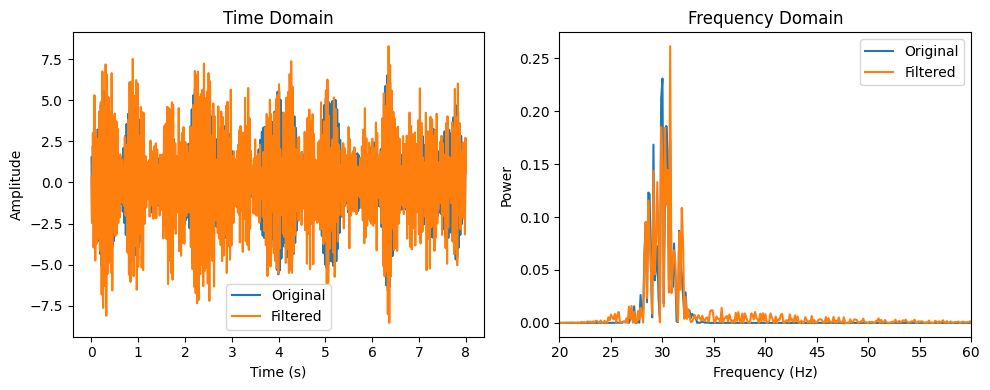

In [11]:
# Generate 1/f noise
N = 8000
fs = 1000
as1 = np.random.rand(N) * np.exp(-np.arange(0, N)/200)
fc = as1 * np.exp(1j * 2 * np.pi * np.random.rand(len(as1)))
noise = np.real(scipy.fftpack.ifft(fc)) * N

# Create frequency-domain Gaussian
hz = np.linspace(0, fs, N)
s = 4 * (2 * np.pi - 1) / (4 * np.pi)
x = hz - 30
fg = np.exp(-0.5 * (x / s)**2)

# Generate signal from Fourier coefficients and add noise
fc = np.random.rand(N) * np.exp(1j * 2 * np.pi * np.random.rand(N))
fc = fc * fg
signal1 = np.real(scipy.fftpack.ifft(fc)) * N
data = signal1 + noise
time = np.arange(0, N) / fs

# Specify filter cutoff (in Hz)
filtcut = 25

# Generate filter coefficients (Butterworth)
filtb, filta = scipy.signal.butter(7, filtcut / (fs / 2), btype='high')

# Filter the data
fdata = scipy.signal.filtfilt(filtb, filta, data)

# Plot time domain comparison
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(time, signal1, label='Original')
plt.plot(time, fdata, label='Filtered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain')

# Power spectra of original and filtered signal
signalX = np.abs(scipy.fftpack.fft(signal1) / N)**2
fdataX = np.abs(scipy.fftpack.fft(fdata) / N)**2
hz = np.linspace(0, fs, N)

# Plot frequency domain comparison
plt.subplot(122)
plt.plot(hz, signalX[:len(hz)], label='Original')
plt.plot(hz, fdataX[:len(hz)], label='Filtered')
plt.xlim([20, 60])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency Domain')

plt.tight_layout()
plt.show()

## Narrow-band filter

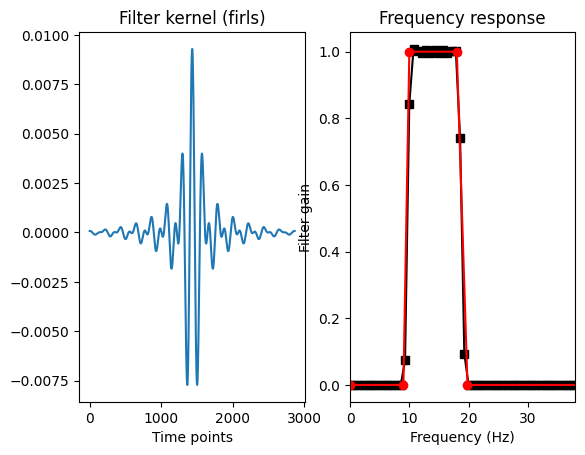

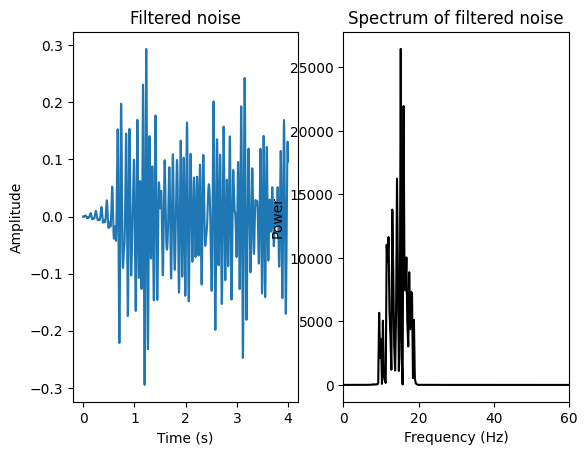

In [12]:
# Define filter parameters
lower_bnd = 10  # Hz
upper_bnd = 18  # Hz
lower_trans = 0.1
upper_trans = 0.1
samprate = 2048  # Hz

# Calculate filter order
filtorder = 14 * np.round(samprate / lower_bnd)
if filtorder % 2 == 0:
    filtorder += 1

# Define the filter shape and frequencies
filter_shape = [0, 0, 1, 1, 0, 0]
filter_freqs = [0, lower_bnd * (1 - lower_trans), lower_bnd, upper_bnd, 
                upper_bnd + upper_bnd * upper_trans, samprate / 2]

# Generate the filter kernel
filterkern = scipy.signal.firls(filtorder, filter_freqs, filter_shape, fs=samprate)

# Frequency axis for plotting the filter's power spectrum
hz = np.linspace(0, samprate / 2, int(np.floor(len(filterkern) / 2) + 1))
filterpow = np.abs(scipy.fftpack.fft(filterkern)) ** 2

# Plot the filter kernel in time domain
plt.subplot(121)
plt.plot(filterkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')

# Plot the filter's frequency response
plt.subplot(122)
plt.plot(hz, filterpow[:len(hz)], 'ks-')
plt.plot(filter_freqs, filter_shape, 'ro-')
plt.xlim([0, upper_bnd + 20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()

# Generate random noise and filter it
filtnoise = scipy.signal.lfilter(filterkern, 1, np.random.randn(samprate * 4))
timevec = np.arange(0, len(filtnoise)) / samprate

# Plot the filtered noise in time domain
plt.subplot(121)
plt.plot(timevec, filtnoise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered noise')

# Plot the power spectrum of the filtered noise
noisepower = np.abs(scipy.fftpack.fft(filtnoise)) ** 2
plt.subplot(122)
plt.plot(np.linspace(0, samprate, len(noisepower)), noisepower, 'k')
plt.xlim([0, 60])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Spectrum of filtered noise')
plt.show()

## Two-stage wide-band filter

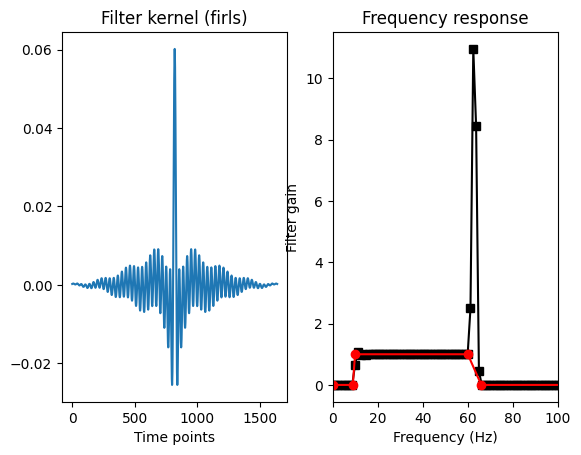

In [13]:
# Define filter parameters
lower_bnd = 10  # Hz
upper_bnd = 60  # Hz
transw = 0.1

samprate = 2048  # Hz
filtorder = 8 * np.round(samprate / lower_bnd) + 1
if filtorder % 2 == 0:
    filtorder += 1  # Ensure odd filter order for symmetry

# Define the filter shape and frequencies
filter_shape = [0, 0, 1, 1, 0, 0]
filter_freqs = [0, lower_bnd * (1 - transw), lower_bnd, upper_bnd, 
                upper_bnd + upper_bnd * transw, samprate / 2]

# Generate the filter kernel
filterkern = scipy.signal.firls(filtorder, filter_freqs, filter_shape, fs=samprate)

# Frequency axis for plotting the filter's power spectrum
hz = np.linspace(0, samprate / 2, int(np.floor(len(filterkern) / 2) + 1))
filterpow = np.abs(scipy.fftpack.fft(filterkern)) ** 2

# Plot the filter kernel in time domain
plt.subplot(121)
plt.plot(filterkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')

# Plot the filter's frequency response
plt.subplot(122)
plt.plot(hz, filterpow[:len(hz)], 'ks-')
plt.plot(filter_freqs, filter_shape, 'ro-')
plt.xlim([0, upper_bnd + 40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()

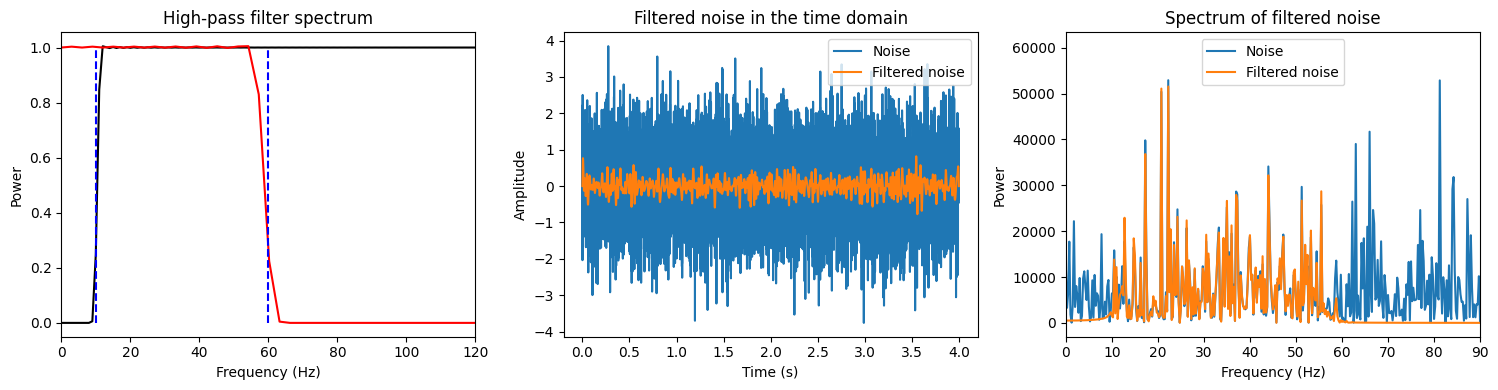

In [14]:
# Define parameters
samprate = 2048  # Hz
lower_bnd = 10   # Hz
upper_bnd = 60   # Hz

# Generate white noise signal
N = samprate * 4
noise = np.random.randn(N)
timevec = np.arange(0, len(noise)) / samprate

# Apply high-pass filter
forder = int(10 * samprate / lower_bnd) + 1
filtkern = scipy.signal.firwin(forder, lower_bnd, pass_zero=False, fs=samprate)

# Spectrum of high-pass filter
hz = np.linspace(0, samprate / 2, int(np.floor(len(filtkern) / 2) + 1))
filterpow = np.abs(scipy.fftpack.fft(filtkern))**2

# Plot high-pass filter spectrum
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(hz, filterpow[:len(hz)], 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('High-pass filter spectrum')

# Apply zero-phase high-pass filtering
fnoise = scipy.signal.filtfilt(filtkern, 1, noise)

# Apply low-pass filter
forder = 20 * int(samprate / upper_bnd) + 1
filtkern = scipy.signal.firwin(forder, upper_bnd, fs=samprate, pass_zero=True)

# Spectrum of low-pass filter
hz = np.linspace(0, samprate / 2, int(np.floor(len(filtkern) / 2) + 1))
filterpow = np.abs(scipy.fftpack.fft(filtkern))**2

plt.subplot(131)
plt.plot(hz, filterpow[:len(hz)], 'r')
plt.plot([lower_bnd, lower_bnd], [0, 1], 'b--')
plt.plot([upper_bnd, upper_bnd], [0, 1], 'b--')
plt.xlim([0, upper_bnd * 2])

# Apply zero-phase low-pass filtering
fnoise = scipy.signal.filtfilt(filtkern, 1, fnoise)

# Plot time-domain signals
plt.subplot(132)
plt.plot(timevec, noise, label='Noise')
plt.plot(timevec, fnoise, label='Filtered noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered noise in the time domain')
plt.legend()

# Power spectrum of original and filtered noise
noiseX = np.abs(scipy.fftpack.fft(noise))**2
fnoiseX = np.abs(scipy.fftpack.fft(fnoise))**2
hz = np.linspace(0, samprate, len(fnoise))

plt.subplot(133)
plt.plot(hz, noiseX, label='Noise')
plt.plot(hz, fnoiseX, label='Filtered noise')
plt.xlim([0, upper_bnd * 1.5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Spectrum of filtered noise')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()